# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-05-25 17:08:04.773783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 17:08:04.773822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 17:08:04.774482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 17:08:04.778458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 17:08:05.390025: W tensorflow/compiler/tf2

In [2]:
# ¿De qué recursos de procesamiento disponemos?
tf.config.list_physical_devices()

2024-05-25 17:08:10.636341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 17:08:10.657418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 17:08:10.657468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(f"Executing in Colab: {IN_COLAB}")

Executing in Colab: False


In [10]:
# Una semilla aleatoria para toda la ejecución
np.random.seed(202)

In [4]:
if IN_COLAB is True:
    # Primero, bajamos los datos de entrenamiento
    keras.utils.get_file(fname="simpsons_train.tar.gz",
                         origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")
    
    # Descomprimimos el archivo
    !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets
    
    
    # Hacemos lo mismo con los datos de test
    keras.utils.get_file(fname="simpsons_test.tar.gz",
                         origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
    !tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [5]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [6]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [7]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [8]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons" if IN_COLAB is True else "./data/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset" if IN_COLAB is True else "./data/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [11]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

abraham_grampa_simpson


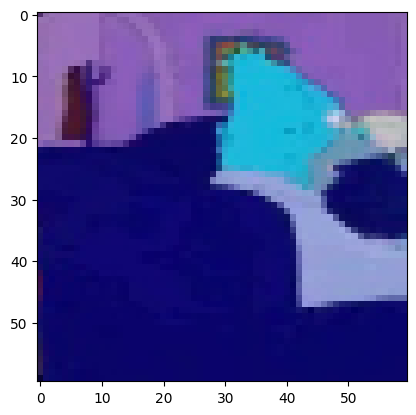

In [12]:
plt.imshow(X_test[2]) # recordad que siempre es preferible trabajar en blanco y negro
print(MAP_CHARACTERS[y_test[2]])

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [13]:
# TENSORFLOW GPU SUPPORT
# ======================
if tf.test.gpu_device_name():
    print("GPU support enabled.")
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU support disabled.")

GPU support enabled.
Default GPU Device: /device:GPU:0


2024-05-25 17:12:14.416581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 17:12:14.416690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 17:12:14.416724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 17:12:14.608741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 17:12:14.608892: I external/local_xla/xla/stream_executor

In [14]:
# TENSORFLOW TPU SUPPORT
# ======================
HAS_TPU_SUPPORT=0
if 'COLAB_TPU_ADDR' not in os.environ:
  print('TPU support disabled.')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU support enabled.')
  HAS_TPU_SUPPORT=1
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()

  print('TPU devices:')
  pprint.pprint(devices)

TPU support disabled.


In [15]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

## 1. Análisis de datos y preparación

El conjunto de datos, originalmente, viene preparado en:
- Datos de entrenamiento.
- Datos de test.

Sin embargo, nos faltaría un conjunto de datos útil: el de validación.

In [16]:
# De los datos de entrenamiento sacamos un 20% de datos para validación.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=202)

Tenemos el siguiente conjunto de datos:
- Entrenamiento: X_train, y_train
- Test: X_test, y_test
- Validación: X_val, y_val

In [17]:
# Variables con numero de elementos
X_train_num_elem = X_train.shape[0]
X_test_num_elem = X_test.shape[0]
X_val_num_elem = X_val.shape[0]

In [18]:
# Dimensiones
img_rows = IMG_SIZE
img_cols = IMG_SIZE
img_channels = X.shape[3]

In [19]:
# Número de categorías
num_categ = len(MAP_CHARACTERS)

In [20]:
# Comprobamos que efectivamente los resultados son los esperados
print("Número de imágenes de anterior training : " + str(X.shape[0]))
print("Número de imágenes de training (80% de anterior train) : " + str(X_train_num_elem))
print("Número de imágenes de validación (20% de anterior train) : " + str(X_val_num_elem))
print("Número de imágenes de test : " + str(X_test_num_elem))
print("====")
print("Número de resultados de anterior training : " + str(y.shape[0]))
print("Número de resultados de training (80% de anterior train) : " + str(y_train.shape[0]))
print("Número de resultadoss de validación (20% de anterior train) : " + str(y_val.shape[0]))
print("Número de resultados de test : " + str(y_test.shape[0]))
print("====")
print("Dimensiones de training : " + str(X_train.shape))
print("Dimensiones de validation : " + str(X_val.shape))
print("Dimensiones de tests : " + str(X_test.shape))
print("====")
print("Canales de color para las imagenes : "+ str(img_channels))
print("Resolución imágenes de anterior training : " + str(X.shape[1]) + "x" + str(X.shape[2]))
print("Resolución imágenes de training (80% de anterior train) : " + str(X_train.shape[1]) + "x" + str(X_train.shape[2]))
print("Resolución imágenes de validación (20% de anterior train) : " + str(X_val.shape[1]) + "x" + str(X_val.shape[2]))
print("Resolución imágenes de test : " + str(X_test.shape[1]) + "x" + str(X_test.shape[2]))

Número de imágenes de anterior training : 18992
Número de imágenes de training (80% de anterior train) : 15193
Número de imágenes de validación (20% de anterior train) : 3799
Número de imágenes de test : 890
====
Número de resultados de anterior training : 18992
Número de resultados de training (80% de anterior train) : 15193
Número de resultadoss de validación (20% de anterior train) : 3799
Número de resultados de test : 890
====
Dimensiones de training : (15193, 60, 60, 3)
Dimensiones de validation : (3799, 60, 60, 3)
Dimensiones de tests : (890, 60, 60, 3)
====
Canales de color para las imagenes : 3
Resolución imágenes de anterior training : 60x60
Resolución imágenes de training (80% de anterior train) : 60x60
Resolución imágenes de validación (20% de anterior train) : 60x60
Resolución imágenes de test : 60x60


In [21]:
# Comprobamos el formato de cada muestra...
if keras.backend.image_data_format() == "channels_first":
  # ...si los canales van primero (channels, rows, cols):
  X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
  X_val = X_val.reshape(X_val.shape[0], img_channels, img_rows, img_cols)
  X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
  input_shape = (img_channels, img_rows, img_cols)
else:
  # ...sino, si los canales van último (rows, cols, channels):
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
  X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, img_channels)
  X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
  input_shape = (img_rows, img_cols, img_channels)

## 2. Normalización de datos

Como hicimos en la primera práctica, tenemos que normalizar los datos

In [22]:
# Normalizamos y convertimos a float32, de tal manera que seamos capaces de tener valores entre 0 y 1
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

# Con esto obtenemos valores entre el rango 0...1
X_train /= 255
X_val /= 255
X_test /= 255

# Con esto conseguimos trabajar con categorías en las y (las etiquetas)
y_train = keras.utils.to_categorical(y_train, num_categ)
y_val = keras.utils.to_categorical(y_val, num_categ)
y_test = keras.utils.to_categorical(y_test, num_categ)

Asi, ya tendríamos preparados todos los conjuntos de datos para poner a definir los modelos con los que vamos a trabajar.

## 3. Entrenamiento

Pasamos a definir los modelos:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M1      |      2      |    Relu    |   Adagrad   |                |
|       M2      |      .      |    .       |      .      |   Fully conn.  |
|       M3      |      4      |    Relu    |   RMSProp   |                |
|       M4      |      6      |    Relu    |   Adadelta  |   Batch norm.  |
|       M5      |      4      |    Relu    |   RMSProp   |   Data augm.   |

==========================
#### 3.1. M1

In [24]:
# Definimos aquí más imports para no tener que ir más arriba en el notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop

In [ ]:
m1 = Sequential()
m1.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m1_conv2d_1"))
m1.add(Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m1_conv2d_2"))
m1.add(MaxPooling2D(pool_size=(2, 2), name="m1_maxpool2d_1"))
m1.add(Dropout(0.25, name="m1_dropout_1"))
m1.add(Flatten(name="m1_flatten"))
m1.add(Dense(128, activation="relu", name="m1_dense_1"))
m1.add(Dropout(0.5, name="m1_dropout_2"))
m1.add(Dense(num_categ, activation="softmax", name="m1_softmax"))

m1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_conv2d_1 (Conv2D)        (None, 58, 58, 32)        896       
                                                                 
 m1_conv2d_2 (Conv2D)        (None, 56, 56, 64)        18496     
                                                                 
 m1_maxpool2d_1 (MaxPooling  (None, 28, 28, 64)        0         
 2D)                                                             
                                                                 
 m1_dropout_1 (Dropout)      (None, 28, 28, 64)        0         
                                                                 
 m1_flatten (Flatten)        (None, 50176)             0         
                                                                 
 m1_dense_1 (Dense)          (None, 128)               6422656   
                                                        

In [ ]:
# Optimizador: ADAGRAD

"""
  Hyperparams:
   - Learning rate (learning_rate): 0.05
"""
m1_opt = Adagrad(learning_rate=0.05)

m1.compile(
    loss="categorical_crossentropy",
    optimizer=m1_opt,
    metrics=["accuracy"]
)

In [26]:
# Entrenamiento
m1_batch_size = 128
m1_epochs = 12

m1_hist = m1.fit(X_train, y_train,
  batch_size=m1_batch_size,
  epochs=m1_epochs,
  verbose=True,
  validation_data=(X_val, y_val)
)

Epoch 1/12
  9/119 [=>............................] - ETA: 3:07 - loss: 0.8079 - accuracy: 0.7465

KeyboardInterrupt: 

In [ ]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m1_hist)
plot_loss(m1_hist)

In [ ]:
# Test
m1_score = m1.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m1_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m1_score[1]))
print("Accuracy (Datos de test) en % : " + str(m1_score[1]*100))

CONCLUSIONES

| Datos | Loss | Accuracy |
| ----- | ---- | -------- |
| Train | 0.458 | 0.851 |
| Validation | 0.901 | 0.753 |
| Test | 0.367 | 0.907 |

Según los resultados obtenidos, hemos superado el 85% de accuracy en entrenamiento y test. Los resultados obtenidos en validación son un poco deficientes, ya que obtenemos una pérdida alta y una accuracy del 75%.

#### 3.2. M2

Es un modelo `fully connected` basándonos en el mejor caso obtenido en la primera actividad.

In [ ]:
from tensorflow.keras.initializers import GlorotUniform, Zeros

In [ ]:
m2 = Sequential()

m2.add(Dense(128, activation="relu", input_shape=input_shape, kernel_initializer=GlorotUniform(), bias_initializer=Zeros(), name="m2_input"))
m2.add(Dense(128, activation="relu", input_shape=input_shape, kernel_initializer=GlorotUniform(), bias_initializer=Zeros(), name="m2_hidden_1"))
m2.add(Dropout(0.1, name="m2_dropout_1"))
m2.add(Flatten(name="m2_flatten"))
m2.add(Dense(128, activation="relu", input_shape=input_shape, kernel_initializer=GlorotUniform(), bias_initializer=Zeros(), name="m2_hidden_2"))
m2.add(Dropout(0.1, name="m2_dropout_2"))
m2.add(BatchNormalization(name="m2_batch_norm_1"))
m2.add(Dense(num_categ, activation="softmax", name="m2_softmax"))

m2.summary()

In [ ]:
# Optimizador: Adam

"""
  Hyperparams:
   - Learning rate (learning_rate): 0.05
   - Beta 1: 0.9
   - Beta 2: 0.999
   - amsgrad (apply the AMSGrad variant) = False
"""
m2_opt = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, amsgrad=False)

m2.compile(
    loss="categorical_crossentropy",
    optimizer=m2_opt,
    metrics=["accuracy"]
)

In [ ]:
# Entrenamiento

m2_batch_size = 128
m2_epochs = 12

m2_hist = m2.fit(X_train, y_train,
  batch_size=m2_batch_size,
  epochs=m2_epochs,
  verbose=True,
  validation_data=(X_val, y_val)
)

In [ ]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m2_hist)
plot_loss(m2_hist)

In [ ]:
# Test
m2_score = m2.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m2_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m2_score[1]))
print("Accuracy (Datos de test) en % : " + str(m2_score[1]*100))

CONCLUSIONES

| Datos | Loss | Accuracy |
| ----- | ---- | -------- |
| Train | 0.316 | 0.898 |
| Validation | 1.951 | 0.680 |
| Test | 0.563 | 0.885 |

Aunque hemos obtenido buenos resultados en el entrenamiento y test con un 89% y 88% de precisión respectivamente, la pérdida de la validación hace indicar que no es una buena opción.

#### 3.3. M3

Ahora vamos a usar 4 capas convolucionales y optimizador RMSProp.

In [ ]:
m3 = Sequential()

m3.add(Conv2D(32, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m3_conv2d_1"))
m3.add(Activation("relu", name="m3_act_1"))
m3.add(Conv2D(32, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m3_conv2d_2"))
m3.add(Activation("relu", name="m3_act_2"))
m3.add(MaxPooling2D(pool_size=(2, 2), name="m3_maxpool2d_1"))
m3.add(Dropout(0.25, name="m3_dropout_1"))

m3.add(Conv2D(64, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m3_conv2d_3"))
m3.add(Activation("relu", name="m3_act_3"))
m3.add(Conv2D(64, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m3_conv2d_4"))
m3.add(Activation("relu", name="m3_act_4"))
m3.add(MaxPooling2D(pool_size=(2, 2), name="m3_maxpool2d_2"))
m3.add(Dropout(0.25, name="m3_dropout_2"))

m3.add(Flatten(name="m3_flatten"))
m3.add(Dense(512, name="m3_dense_1"))
m3.add(Activation("relu", name="m3_act_5"))
m3.add(Dropout(0.5, name="m3_dropout_3"))
m3.add(Dense(num_categ, name="m3_dense_2"))
m3.add(Activation("softmax", name="m3_act_6"))

m3.summary()

In [ ]:
# Optimizador: RMSprop

"""
  Hyperparams:
   - Learning rate (learning_rate): 0.02
   - rho (Gradient moving average) = 0.9
"""
m3_opt = RMSprop(learning_rate=0.02, rho=0.9)

m3.compile(
    loss="categorical_crossentropy",
    optimizer=m3_opt,
    metrics=["accuracy"]
)

In [ ]:
# Entrenamiento

m3_batch_size = 128
m3_epochs = 12

m3_hist = m3.fit(X_train, y_train,
  batch_size=m3_batch_size,
  epochs=m3_epochs,
  verbose=True,
  validation_data=(X_val, y_val)
)

In [ ]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m3_hist)
plot_loss(m3_hist)

In [ ]:
# Test
m3_score = m3.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m3_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m3_score[1]))
print("Accuracy (Datos de test) en % : " + str(m3_score[1]*100))

CONCLUSIONES

| Datos | Loss | Accuracy |
| ----- | ---- | -------- |
| Train |  |  |
| Validation |  |  |
| Test |  |  |

TODO

#### 3.4. M4

Ahora vamos a usar 6 capas convolucionales, optimizador Adadelta y Batch Normalization.

In [38]:
m4 = Sequential()

m4.add(Conv2D(32, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m4_conv2d_1"))
m4.add(Activation("relu", name="m4_act_1"))
m4.add(BatchNormalization(name="m4_batch_norm_1"))
m4.add(Conv2D(32, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m4_conv2d_2"))
m4.add(Activation("relu", name="m4_act_2"))
m4.add(BatchNormalization(name="m4_batch_norm_2"))
m4.add(MaxPooling2D(pool_size=(2, 2), name="m4_maxpool2d_1"))
m4.add(Dropout(0.25, name="m4_dropout_1"))

m4.add(Conv2D(64, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m4_conv2d_3"))
m4.add(Activation("relu", name="m4_act_3"))
m4.add(BatchNormalization(name="m4_batch_norm_3"))
m4.add(Conv2D(64, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m4_conv2d_4"))
m4.add(Activation("relu", name="m4_act_4"))
m4.add(BatchNormalization(name="m4_batch_norm_4"))
m4.add(MaxPooling2D(pool_size=(2, 2), name="m4_maxpool2d_2"))
m4.add(Dropout(0.25, name="m4_dropout_2"))


m4.add(Conv2D(256, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m4_conv2d_5"))
m4.add(Activation("relu", name="m4_act_5"))
m4.add(BatchNormalization(name="m4_batch_norm_5"))
m4.add(Conv2D(256, kernel_size=(3, 3), padding="same", input_shape=input_shape, name="m4_conv2d_6"))
m4.add(Activation("relu", name="m4_act_6"))
m4.add(BatchNormalization(name="m4_batch_norm_6"))
m4.add(MaxPooling2D(pool_size=(2, 2), name="m4_maxpool2d_3"))
m4.add(Dropout(0.25, name="m4_dropout_3"))


m4.add(Flatten(name="m4_flatten"))
m4.add(Dense(2048, name="m4_dense_1"))
m4.add(Activation("relu", name="m4_act_7"))
m4.add(BatchNormalization(name="m4_batch_norm_7"))
m4.add(Dropout(0.5, name="m4_dropout_4"))
m4.add(Dense(num_categ, name="m4_dense_2"))
m4.add(Activation("softmax", name="m4_act_8"))

m4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m4_conv2d_1 (Conv2D)        (None, 60, 60, 32)        896       
                                                                 
 m4_act_1 (Activation)       (None, 60, 60, 32)        0         
                                                                 
 m4_batch_norm_1 (BatchNorm  (None, 60, 60, 32)        128       
 alization)                                                      
                                                                 
 m4_conv2d_2 (Conv2D)        (None, 60, 60, 32)        9248      
                                                                 
 m4_act_2 (Activation)       (None, 60, 60, 32)        0         
                                                                 
 m4_batch_norm_2 (BatchNorm  (None, 60, 60, 32)        128       
 alization)                                           

In [39]:
# Optimizador: Adadelta

"""
  Hyperparams:
   - Learning rate (learning_rate): 0.01
   - rho = 0.9
"""
m4_opt = Adadelta(learning_rate=0.01, rho=0.9)

m4.compile(
    loss="categorical_crossentropy",
    optimizer=m4_opt,
    metrics=["accuracy"]
)

In [40]:
# Entrenamiento

m4_batch_size = 128
m4_epochs = 24

m4_hist = m4.fit(X_train, y_train,
  batch_size=m4_batch_size,
  epochs=m4_epochs,
  verbose=True,
  validation_data=(X_val, y_val)
)

Epoch 1/24


2024-05-25 17:29:38.144524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/m4_dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 [==============================] - 14s 101ms/step - loss: 3.8956 - accuracy: 0.1100 - val_loss: 3.2971 - val_accuracy: 0.0692
Epoch 2/24
119/119 [==============================] - 12s 98ms/step - loss: 3.3275 - accuracy: 0.1992 - val_loss: 3.5345 - val_accuracy: 0.0705
Epoch 3/24
119/119 [==============================] - 12s 98ms/step - loss: 3.0078 - accuracy: 0.2576 - val_loss: 3.2829 - val_accuracy: 0.1242
Epoch 4/24
119/119 [==============================] - 12s 98ms/step - loss: 2.7671 - accuracy: 0.3079 - val_loss: 2.6478 - val_accuracy: 0.2469
Epoch 5/24
119/119 [==============================] - 12s 98ms/step - loss: 2.6293 - accuracy: 0.3417 - val_loss: 2.1902 - val_accuracy: 0.3482
Epoch 6/24
119/119 [==============================] - 12s 98ms/step - loss: 2.4917 - accuracy: 0.3706 - val_loss: 1.8979 - val_accuracy: 0.4351
Epoch 7/24
119/119 [==============================] - 12s 99ms/step - loss: 2.3689 - accuracy: 0.3996 - val_loss: 1.7841 - val_accuracy: 0.4696
Ep

In [ ]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m4_hist)
plot_loss(m4_hist)

In [ ]:
# Test
m4_score = m4.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m4_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m4_score[1]))
print("Accuracy (Datos de test) en % : " + str(m4_score[1]*100))

CONCLUSIONES

| Datos | Loss | Accuracy |
| ----- | ---- | -------- |
| Train |  |  |
| Validation |  |  |
| Test |  |  |

TODO

TODO:

Hacer matrices de confusión y f-1 score de todas las clases a predecir.

CONCLUSIONES

| Datos | Loss | Accuracy |
| ----- | ---- | -------- |
| Train |  |  |
| Validation |  |  |
| Test |  |  |

TODO